In the Data folder file I showed that t>20 basically corresponds to noise. Here I want to check if the network performance improves if I throw out this noise.

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn

sys.path.append('../scripts')
sys.path.append('../models')

from sklearn.model_selection import train_test_split
import sys
from scipy.ndimage import rotate
import math
import random
from output_statistics import *

from tensorboard.backend.event_processing import event_accumulator

dimensions = 22 # for data reduction
trancuate_t = 96 # set this parameter to control at which time step you stop using the signal
import plotly.graph_objects as go
k = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

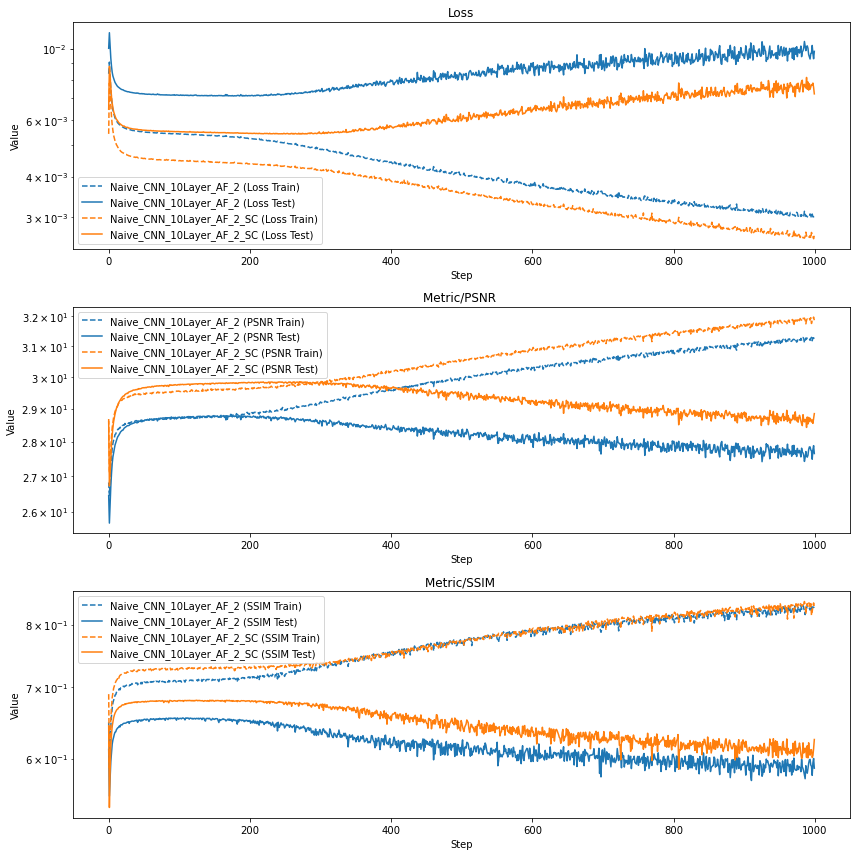

In [9]:
test = True # display test error
train = True # display train error


Naive_CNN_10Layer_AF_3 = "../log_files/Naive_CNN_3D_AF_3_possoin_r0_Low2Low/10Layer/events.out.tfevents.1738770938.f9c97f3588bc.7011.0"
Naive_CNN_10Layer_AF_3_SC = "../log_files/Naive_CNN_3D_AF_3_possoin_r0_Low2Low_SC/10Layer/events.out.tfevents.1738770949.f9c97f3588bc.7114.0"

Naive_CNN_10Layer_AF_2 = "../log_files/Naive_CNN_3D_AF_2_possoin_r0_Low2Low/10Layer/events.out.tfevents.1738771124.30adc46d0bc7.17387.0"
Naive_CNN_10Layer_AF_2_SC = "../log_files/Naive_CNN_3D_AF_2_possoin_r0_Low2Low_SC/10Layer/events.out.tfevents.1738771055.f9c97f3588bc.7223.0"

# Am 5.2 Am abend gestartet AF 2 & AF 3 Naive CNN Low2Low als auch SC

logdirs = [Naive_CNN_10Layer_AF_2, Naive_CNN_10Layer_AF_2_SC]

labels = ["Naive_CNN_10Layer_AF_2", "Naive_CNN_10Layer_AF_2_SC"]

# You can define the metrics you want to compare. For example:
my_metrics = [
    ("Loss Train", "Loss/Train"),
    ("Loss Test",  "Loss/Test"),
    ("PSNR Train", "Metric/PSNR /Train"),
    ("PSNR Test",  "Metric/PSNR /Test"),
    ("SSIM Train", "Metric/SSIM /Train"),
    ("SSIM Test",  "Metric/SSIM /Test"),
]

compare_models(
    logdirs=logdirs,
    model_labels=labels,
    metrics=my_metrics,
    figsize=(12, 12),
    train = train,
    test = test
)

In [11]:
Inspect = "Loss/Test"   #SSIM Train     Loss/Test
logdir = Naive_CNN_10Layer_AF_2

# Load the experiment data
ea = event_accumulator.EventAccumulator(logdir)
ea.Reload()  # Loads the log data

loss_data = {}

    # Extract Train Loss
if "Loss/Train" in ea.Tags()['scalars']:
    loss_train = ea.Scalars("Loss/Train")
    loss_data["Loss/Train"] = [(x.step, x.value) for x in loss_train]

    # Extract Test Loss
if "Loss/Test" in ea.Tags()['scalars']:
    loss_test = ea.Scalars("Loss/Test")
    loss_data["Loss/Test"] = [(x.step, x.value) for x in loss_test]
    
loss_test

[ScalarEvent(wall_time=1738771138.2523403, step=0, value=0.010022264905273914),
 ScalarEvent(wall_time=1738771150.75305, step=1, value=0.011206493712961674),
 ScalarEvent(wall_time=1738771163.8591633, step=2, value=0.01017752941697836),
 ScalarEvent(wall_time=1738771177.125665, step=3, value=0.009340977296233177),
 ScalarEvent(wall_time=1738771190.7152689, step=4, value=0.00880223885178566),
 ScalarEvent(wall_time=1738771204.843379, step=5, value=0.008435252122581005),
 ScalarEvent(wall_time=1738771219.0939627, step=6, value=0.008215770125389099),
 ScalarEvent(wall_time=1738771233.79442, step=7, value=0.008077544160187244),
 ScalarEvent(wall_time=1738771248.3254778, step=8, value=0.007960616610944271),
 ScalarEvent(wall_time=1738771263.4413486, step=9, value=0.007848136126995087),
 ScalarEvent(wall_time=1738771278.129105, step=10, value=0.00778124388307333),
 ScalarEvent(wall_time=1738771293.7088983, step=11, value=0.007722355425357819),
 ScalarEvent(wall_time=1738771309.0468786, step=